# Training the Language-Based Type Estimator

## Boilerplate

* For code change detection
* Seeing log messages inside the notebook
* Checking TensorFlow configuration.
* Setting random seeds

In [1]:
%load_ext autoreload
%autoreload 2

SEED: int = 42

import logging
logger: logging.Logger = logging.getLogger()
logger.setLevel(logging.INFO)

import tensorflow as tf
tf.random.set_seed(SEED)

import numpy as np
np.random.seed(SEED)

logging.info(f"Tensorflow version {tf.__version__}")
logging.info(f"Devices available: {tf.config.list_physical_devices()}")

logging.info("Starting analysis...")

2022-12-28 11:29:12.382762: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-28 11:29:12.458493: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-28 11:29:12.809822: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-28 11:29:12.809861: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

## Data Exploration

Checking label counts on the training dataset

<AxesSubplot: xlabel='will_help', ylabel='count'>

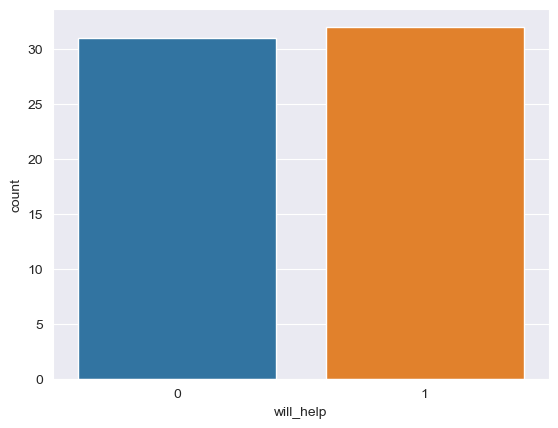

In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns

TRAINING_DATA_CSV_FILE = "data/training_data.csv"
training_dataset: pd.DataFrame = pd.read_csv(TRAINING_DATA_CSV_FILE)
validation_dataset: pd.DataFrame
training_dataset, validation_dataset = train_test_split(training_dataset, test_size=0.5)

sns.countplot(x="will_help", data=training_dataset)

## Sanity Checks

Let's train on a single sample, to verify data loading is working fine. We expect perfect accuracy after a few iterations.

In [3]:
from transformer_analyser import TransformerTypeAnalyser

type_analyser: TransformerTypeAnalyser = TransformerTypeAnalyser(epochs=5)
# type_analyser.train(training_dataset.head(1))

Instead of a single sample, we now train over a very small dataset. Again, we expect perfect accuracy after a few iterations.

In [4]:
small_sample: pd.DataFrame
_, small_sample = train_test_split(training_dataset, test_size=0.07, stratify=training_dataset["will_help"])

logging.info(small_sample["will_help"].value_counts())
type_analyser = TransformerTypeAnalyser(epochs=10)
# type_analyser.train(small_sample)


INFO:root:1    3
0    2
Name: will_help, dtype: int64


## Training the model
Training and validating with holdout data

In [5]:
type_analyser = TransformerTypeAnalyser(epochs=15, batch_size=8, learning_rate=3e-5)
type_analyser.train(training_data=training_dataset, testing_data=validation_dataset)


INFO:root:Starting training...
2022-12-28 11:29:14.497411: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-28 11:29:14.498477: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-28 11:29:14.498762: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-28 11:29:14.498926: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...bert
......embeddings
.........LayerNorm
............vars
...............0
...............1
.........dropout
............vars
.........vars
............0
............1
............2
......encoder
.........layer
............tf_bert_layer
...............attention
..................dense_output
.....................LayerNorm
........................vars
...........................0
...........................1
.....................dense
........................vars
...........................0
...........................1
.....................dropout
........................vars
.....................vars
..................self_attention
.....................dropout
........................vars
.....................key
........................vars
...........................0
...........................1
.....................query
........................vars
...........................0
...........................1
.....

  0%|          | 0/1 [00:00<?, ?ba/s]

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...bert
......embeddings
.........LayerNorm
............vars
...............0
...............1
.........dropout
............vars
.........vars
............0
............1
............2
......encoder
.........layer
............tf_bert_layer
...............attention
..................dense_output
.....................LayerNorm
........................vars
...........................0
...........................1
.....................dense
........................vars
...........................0
...........................1
.....................dropout
........................vars
.....................vars
..................self_attention
.....................dropout
........................vars
.....................key
........................vars
...........................0
...........................1
.....................query
........................vars
...........................0
...........................1
.....

  0%|          | 0/1 [00:00<?, ?ba/s]

INFO:root:Encoding finished. Starting training


Epoch 1/15


2022-12-28 11:29:30.933805: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f2094010ad0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-12-28 11:29:30.933824: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA RTX A5000 Laptop GPU, Compute Capability 8.6
2022-12-28 11:29:30.936854: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-12-28 11:29:31.022371: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-12-28 11:29:31.023246: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234]

2/8 [======>.......................] - ETA: 2s - loss: 0.6970 - sparse_categorical_accuracy: 0.4375  

2022-12-28 11:29:40.259264: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


3/8 [==========>...................] - ETA: 1s - loss: 0.7442 - sparse_categorical_accuracy: 0.3750

2022-12-28 11:29:40.597249: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


4/8 [==============>...............] - ETA: 1s - loss: 0.7240 - sparse_categorical_accuracy: 0.4062

2022-12-28 11:29:40.932391: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


5/8 [=================>............] - ETA: 1s - loss: 0.7179 - sparse_categorical_accuracy: 0.4500

2022-12-28 11:29:41.271985: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


6/8 [=====================>........] - ETA: 0s - loss: 0.6950 - sparse_categorical_accuracy: 0.5000

2022-12-28 11:29:41.609360: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


8/8 [==============================] - ETA: 0s - loss: 0.6944 - sparse_categorical_accuracy: 0.4762

2022-12-28 11:29:42.258975: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


8/8 [==============================] - 26s 720ms/step - loss: 0.6944 - sparse_categorical_accuracy: 0.4762 - val_loss: 0.5948 - val_sparse_categorical_accuracy: 0.8254
Epoch 2/15
1/8 [==>...........................] - ETA: 2s - loss: 0.5540 - sparse_categorical_accuracy: 1.0000

2022-12-28 11:29:45.302813: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


4/8 [==============>...............] - ETA: 1s - loss: 0.5371 - sparse_categorical_accuracy: 0.9375

2022-12-28 11:29:46.320879: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


6/8 [=====================>........] - ETA: 0s - loss: 0.5100 - sparse_categorical_accuracy: 0.9583

2022-12-28 11:29:46.983143: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


7/8 [=========================>....] - ETA: 0s - loss: 0.4999 - sparse_categorical_accuracy: 0.9643

2022-12-28 11:29:47.326315: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


8/8 [==============================] - 4s 494ms/step - loss: 0.5114 - sparse_categorical_accuracy: 0.9365 - val_loss: 0.4728 - val_sparse_categorical_accuracy: 0.8889
Epoch 3/15
1/8 [==>...........................] - ETA: 2s - loss: 0.4316 - sparse_categorical_accuracy: 0.8750

2022-12-28 11:29:49.092199: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


3/8 [==========>...................] - ETA: 1s - loss: 0.3767 - sparse_categorical_accuracy: 0.9583

2022-12-28 11:29:49.767660: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


4/8 [==============>...............] - ETA: 1s - loss: 0.3602 - sparse_categorical_accuracy: 0.9688

2022-12-28 11:29:50.104743: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


5/8 [=================>............] - ETA: 1s - loss: 0.3412 - sparse_categorical_accuracy: 0.9750

2022-12-28 11:29:50.441399: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


7/8 [=========================>....] - ETA: 0s - loss: 0.3336 - sparse_categorical_accuracy: 0.9464

2022-12-28 11:29:51.114958: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


8/8 [==============================] - 4s 480ms/step - loss: 0.3285 - sparse_categorical_accuracy: 0.9524 - val_loss: 0.3901 - val_sparse_categorical_accuracy: 0.8413
Epoch 4/15
1/8 [==>...........................] - ETA: 2s - loss: 0.2017 - sparse_categorical_accuracy: 1.0000

2022-12-28 11:29:52.790902: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


3/8 [==========>...................] - ETA: 1s - loss: 0.1984 - sparse_categorical_accuracy: 1.0000

2022-12-28 11:29:53.462975: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


5/8 [=================>............] - ETA: 1s - loss: 0.1848 - sparse_categorical_accuracy: 1.0000

2022-12-28 11:29:54.140079: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


8/8 [==============================] - 4s 492ms/step - loss: 0.1708 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.3551 - val_sparse_categorical_accuracy: 0.8571
Epoch 5/15
1/8 [==>...........................] - ETA: 2s - loss: 0.1353 - sparse_categorical_accuracy: 1.0000

2022-12-28 11:29:56.567211: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


6/8 [=====================>........] - ETA: 0s - loss: 0.0959 - sparse_categorical_accuracy: 1.0000

2022-12-28 11:29:58.250568: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


7/8 [=========================>....] - ETA: 0s - loss: 0.0931 - sparse_categorical_accuracy: 1.0000

2022-12-28 11:29:58.594597: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


8/8 [==============================] - 4s 486ms/step - loss: 0.0905 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.3399 - val_sparse_categorical_accuracy: 0.8571
Epoch 6/15
2/8 [======>.......................] - ETA: 2s - loss: 0.0631 - sparse_categorical_accuracy: 1.0000

2022-12-28 11:30:00.638995: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


3/8 [==========>...................] - ETA: 1s - loss: 0.0584 - sparse_categorical_accuracy: 1.0000

2022-12-28 11:30:00.977225: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


4/8 [==============>...............] - ETA: 1s - loss: 0.0572 - sparse_categorical_accuracy: 1.0000

2022-12-28 11:30:01.321787: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


5/8 [=================>............] - ETA: 1s - loss: 0.0561 - sparse_categorical_accuracy: 1.0000

2022-12-28 11:30:01.655279: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


7/8 [=========================>....] - ETA: 0s - loss: 0.0536 - sparse_categorical_accuracy: 1.0000

2022-12-28 11:30:02.361975: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


8/8 [==============================] - 4s 468ms/step - loss: 0.0520 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.3453 - val_sparse_categorical_accuracy: 0.8730
Epoch 7/15
5/8 [=================>............] - ETA: 1s - loss: 0.0351 - sparse_categorical_accuracy: 1.0000

2022-12-28 11:30:05.257119: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


8/8 [==============================] - 4s 466ms/step - loss: 0.0329 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.3735 - val_sparse_categorical_accuracy: 0.8730
Epoch 8/15
8/8 [==============================] - ETA: 0s - loss: 0.0222 - sparse_categorical_accuracy: 1.0000

2022-12-28 11:30:09.848088: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


8/8 [==============================] - 4s 464ms/step - loss: 0.0222 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.4037 - val_sparse_categorical_accuracy: 0.8730
Epoch 9/15
8/8 [==============================] - 4s 465ms/step - loss: 0.0167 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.4255 - val_sparse_categorical_accuracy: 0.8730
Epoch 10/15
4/8 [==============>...............] - ETA: 1s - loss: 0.0128 - sparse_categorical_accuracy: 1.0000

2022-12-28 11:30:15.703750: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


5/8 [=================>............] - ETA: 1s - loss: 0.0132 - sparse_categorical_accuracy: 1.0000

2022-12-28 11:30:16.042259: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


8/8 [==============================] - ETA: 0s - loss: 0.0125 - sparse_categorical_accuracy: 1.0000

2022-12-28 11:30:17.022475: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


Restoring model weights from the end of the best epoch: 5.
8/8 [==============================] - 4s 479ms/step - loss: 0.0125 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.4431 - val_sparse_categorical_accuracy: 0.8571
Epoch 10: early stopping


INFO:root:Model and Tokenizer saved at ./model
